# Time-aware smoothing for user ratings
Save several different time windows (1-6 months) for later hyper param tuning

# Imports and general info

In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import scipy
import psycopg2
from collections import defaultdict
from os.path import exists
con = psycopg2.connect(database='codeforces', user='Joy')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['figure.facecolor'] = 'white'

/usr/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
db = 'codeforces'
usr = 'Joy'
con = psycopg2.connect(database = db, user = usr)
cur = con.cursor()

Print the tables currently in the database

In [4]:
cur.execute("""
SELECT
    table_schema || '.' || table_name
FROM
    information_schema.tables
WHERE
    table_type = 'BASE TABLE'
AND
    table_schema NOT IN ('pg_catalog', 'information_schema');
    """)
rows = cur.fetchall()
for r in rows:
    print r

('public.handles',)
('public.submissions',)
('public.contests',)
('public.tags',)
('public.hacks',)
('public.user_rating',)
('public.problem_rating',)
('public.problem_info',)


# Data smoothing

Use a time-aware filter to get the smoothed data from the last $x$ months

In [4]:
cur.execute("""SELECT handle FROM handles;""")
handles = [x[0] for x in cur.fetchall()]

(26, 7)
(26, 12)


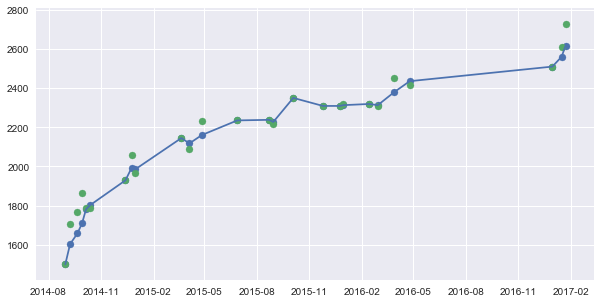

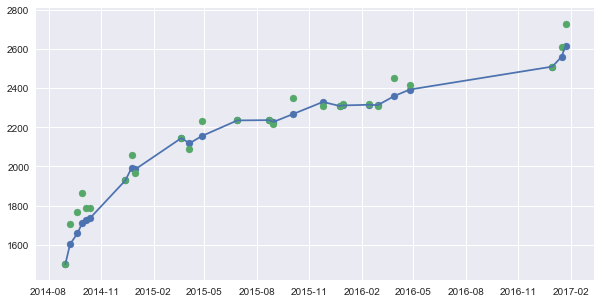

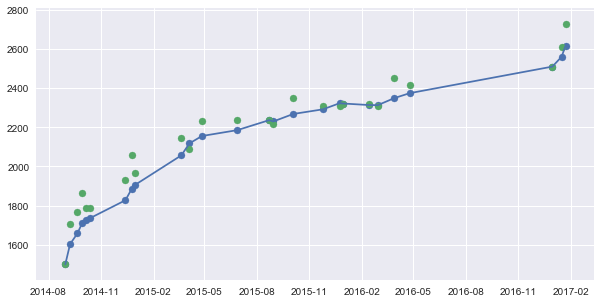

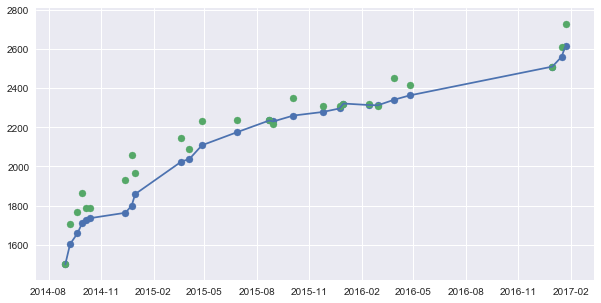

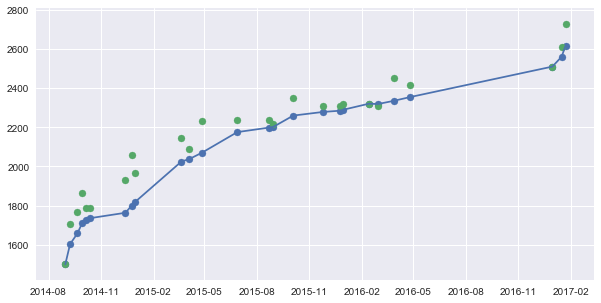

In [3]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
user= 'waterfalls'
df = pd.read_sql("select * from user_rating where handle = '%s' order by ratingupdatetimeseconds" % user, con)
print df.shape

for n_months in range(1, 6):
    # use a time-aware rolling window
    timepassed = 3600*24*30*n_months
    df['time'] = pd.to_datetime(df.ratingupdatetimeseconds, unit='s').apply(pd.Timestamp)
    df.set_index('time', inplace=True)

    smooth_rating = df.oldrating.rolling('%ds' % timepassed, center=False).mean()
    df['smoothed_%dmonths'%n_months] = smooth_rating
    plt.figure()
    plt.plot(df.index, smooth_rating)
    plt.scatter(df.index, smooth_rating)
    plt.scatter(df.index, df.oldrating.values)
print df.shape
    

##  Run for all handles

In [4]:
df_user_rating = pd.read_sql("select * from user_rating", con)
df_user_rating['time'] = pd.to_datetime(df_user_rating.ratingupdatetimeseconds, unit='s').apply(pd.Timestamp)
group_user_rating = df_user_rating.groupby('handle')

In [ ]:
filename = 'user_ratings_smoothed.csv'
for user, df in group_user_rating:
    df.is_copy = False
    df.sort_values('time', inplace=True)
    df.set_index('time', inplace=True)
    oldrows = df.shape[0]
    
    for n_months in range(1, 6):
        # use a time-aware rolling window
        timepassed = 3600*24*30*n_months
#        df['time'] = pd.to_datetime(df.ratingupdatetimeseconds, unit='s').apply(pd.Timestamp)

        smooth_rating = df.oldrating.rolling('%ds' % timepassed, center=False).mean()
        df['smoothed_%dmonths'%n_months] = smooth_rating
    df.reset_index(inplace=True)
    
    assert(oldrows == df.shape[0])
    
    if exists(filename):
        df.to_csv(filename, mode='a', header=False, index=False)
    else:
        df.to_csv(filename, mode='a', header=True, index=False)

In [206]:
handles.index('last_nope')

50658

In [208]:
handles[50659]

'leoric'

In [8]:
dfs = pd.read_csv('user_ratings_smoothed.csv')
dfu = pd.read_csv('rating_histories.csv')

ss = set(dfs.handle)
su = set(dfu.handle)

missing = su.difference(ss)

missing

In [220]:
filename = 'user_ratings_smoothed.csv'
last_idx = 0
for i, user in enumerate(missing):
    print last_idx + i
    df = pd.read_sql("select * from user_rating where handle = '%s' order by ratingupdatetimeseconds" % user, con)

    for n_months in range(1, 6):
        # use a time-aware rolling window
        timepassed = 3600*24*30*n_months
        df['time'] = pd.to_datetime(df.ratingupdatetimeseconds, unit='s').apply(pd.Timestamp)
        df.set_index('time', inplace=True)

        smooth_rating = df.newrating.rolling('%ds' % timepassed, center=False).mean()
        df['smoothed_%dmonths'%n_months] = smooth_rating
    df.reset_index(inplace=True)
    
    if exists(filename):
        df.to_csv(filename, mode='a', header=False, index=False)
    else:
        df.to_csv(filename, mode='a', header=True, index=False)
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
from sqlalchemy import create_engine
engine = create_engine('postgres://%s@localhost/%s'%('Joy', 'codeforces'))

dfs.to_sql('user_rating_smooth', engine, if_exists='replace')